In [462]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [463]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

def Ours(a, b, gamma, scale=1):
    return (scale*Carlsten(alpha=a, beta=b, gamma=gamma) + calcAOverAHGamma(a=a, b=b, gamma=gamma)) / (scale + 1)

# 3d plot showing best beta-cutoff value vs. selfish curve vs honest

In [464]:
# first, theoretical
alpha  = 0.3
betas  = np.arange(0.01, 10.01, 0.01)
gammas = np.arange(0, 1.01, 0.01)
scales = [1/10, 1, 10]
bCutoffRews = []
selfishRews = []
for scale in tqdm(scales):
    temp, temp2 = [], []
    for g in gammas:
        temp.append(np.array([Ours(a=alpha, b=b, gamma=g, scale=scale) for b in betas]))
        temp2.append(np.array([Ours(a=alpha, b=30, gamma=g, scale=scale)]*len(betas)))
    bCutoffRews.append(temp)
    selfishRews.append(temp2)
bCutoffRews = np.array(bCutoffRews)
selfishRews = np.array(selfishRews)
bCutoffRews.shape, selfishRews.shape

100%|██████████| 3/3 [00:13<00:00,  4.47s/it]


((3, 101, 1000), (3, 101, 1000))

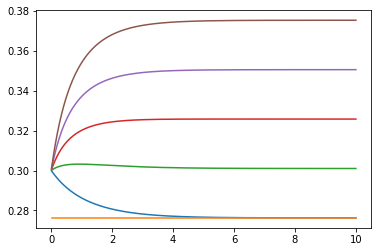

In [465]:
plt.plot(betas, bCutoffRews[0][0])
plt.plot(betas, selfishRews[0][0])
plt.plot(betas, bCutoffRews[0][25])
plt.plot(betas, bCutoffRews[0][50])
plt.plot(betas, bCutoffRews[0][75])
plt.plot(betas, bCutoffRews[0][100])

In [466]:
betas, gammas = np.meshgrid(betas, gammas)
betas.shape, gammas.shape

((101, 1000), (101, 1000))

In [467]:
bCutoffRews[0].shape, selfishRews[0].shape

((101, 1000), (101, 1000))

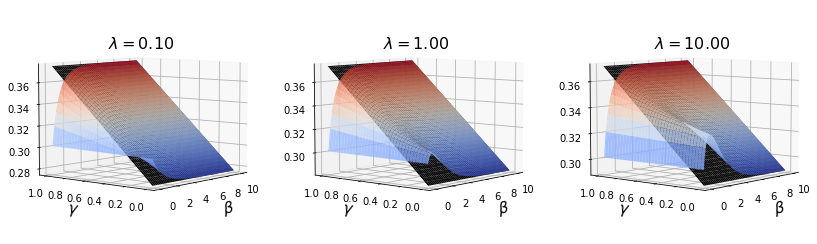

In [488]:
f, axarr = plt.subplots(ncols=3, figsize=(14,7), subplot_kw={"projection": "3d"})

for i in range(3):
    axarr[i].plot_surface(betas, gammas, selfishRews[i], color='k', alpha=1)
    axarr[i].plot_surface(betas, gammas, bCutoffRews[i], cmap=mpl.cm.coolwarm, alpha=0.8)

    axarr[i].view_init(elev=6, azim=220)
    axarr[i].text2D(0.5, 0.82, r'$\lambda=${:0.2f}'.format(scales[i]), 
                    transform=axarr[i].transAxes, ha='center', size=16)
    
    
for i, ax in enumerate(axarr):
    ax.set_xlabel(r'$\beta$', size=15)
    ax.set_ylabel(r'$\gamma$', size=15)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [62]:
alpha  = 0.3
gammas = [0., 0.5, 1.]
scale  = 1
betas  = np.arange(0.01, 10, 0.01)
theoRews = []
for gamma in gammas:
    theoRews.append([Ours(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas])
theoRews = np.asarray(theoRews)
theoRews.shape

(3, 999)

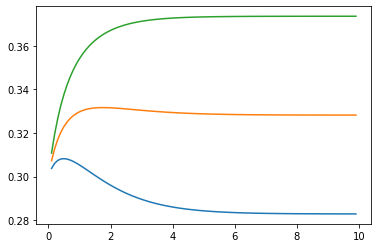

In [51]:
plt.plot(betas, theoRews[0])
plt.plot(betas, theoRews[1])
plt.plot(betas, theoRews[2])

In [53]:
def sim_beta_linear(alpha, gamma, beta, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential() # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    return attackRews, honestRews, attackBlcs, honestBlcs

In [75]:
def sim_beta_nonlinear(alpha, gamma, beta, f, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = f() # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    return attackRews, honestRews, attackBlcs, honestBlcs

In [61]:
simBetas  = np.arange(0.01, 10.02, 1.)
simRews   = []
gammas    = [0., 0.5, 1.]
for gamma in gammas:
    tempOut = []
    for b in simBetas:
        print('gamma={:0.3f},beta={:0.3f}'.format(gamma, b), end='\r')
        temp = []
        for j in range(10):
            ar, hr, ab, hb = sim_beta_linear(alpha=0.3, gamma=gamma, beta=b, n=int(1e5))
            temp.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
        tempOut.append(np.mean(temp))
    simRews.append(tempOut)
simRews = np.array(simRews)
simRews.shape

(3, 11)

In [136]:
np.random.exponential() + np.random.binomial(n=1, p=0.1)

0.007539249319994241

In [351]:
np.random.pareto(a=1)

3.449219781848993

In [356]:
def linearPlusBernoulliTrial():
    return np.random.exponential() + np.random.binomial(n=1, p=0.1)

def timeSquared():
    return (1+np.random.exponential())**2 - 1

def timeSquareRt():
    return np.sqrt(np.random.exponential())

def pareto():
    return np.random.pareto(a=1)

def linearPlusSqrt():
    time = np.random.exponential()
    return time + np.sqrt(time)

In [178]:
simBetas  = np.arange(0.01, 10.02, 1.)
berRews   = []
gammas    = [0., 0.5, 1.]
for gamma in gammas:
    tempOut = []
    for b in simBetas:
        print('gamma={:0.3f},beta={:0.3f}'.format(gamma, b), end='\r')
        temp = []
        for j in range(10):
            ar, hr, ab, hb = sim_beta_nonlinear(alpha=0.3, gamma=gamma, beta=b, 
                                                f=timeSquared, n=int(1e5))
            temp.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
        tempOut.append(np.mean(temp))
    berRews.append(tempOut)
berRews = np.array(berRews)
berRews.shape

(3, 11)

In [188]:
simBetas  = np.arange(0.01, 10.02, 1.)
sqrRews   = []
gammas    = [0., 0.5, 1.]
for gamma in gammas:
    tempOut = []
    for b in simBetas:
        print('gamma={:0.3f},beta={:0.3f}'.format(gamma, b), end='\r')
        temp = []
        for j in range(10):
            ar, hr, ab, hb = sim_beta_nonlinear(alpha=0.3, gamma=gamma, beta=b, 
                                                f=timeSquareRt, n=int(1e5))
            temp.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
        tempOut.append(np.mean(temp))
    sqrRews.append(tempOut)
sqrRews = np.array(sqrRews)
sqrRews.shape

(3, 11)

In [357]:
simBetas  = np.arange(0.01, 10.02, 1.)
lirRews   = []
gammas    = [0., 0.5, 1.]
for gamma in gammas:
    tempOut = []
    for b in simBetas:
        print('gamma={:0.3f},beta={:0.3f}'.format(gamma, b), end='\r')
        temp = []
        for j in range(10):
            ar, hr, ab, hb = sim_beta_nonlinear(alpha=0.3, gamma=gamma, beta=b, 
                                                f=linearPlusSqrt, n=int(1e5))
            temp.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
        tempOut.append(np.mean(temp))
    lirRews.append(tempOut)
lirRews = np.array(lirRews)
lirRews.shape

(3, 11)

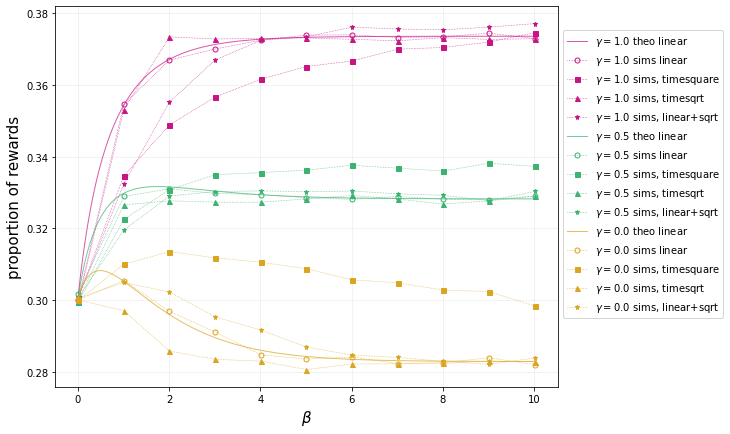

In [361]:
f, ax = plt.subplots(figsize=(9,7))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [2,1,0]:
    ax.plot(betas, theoRews[i], linewidth=1, color=colors[i], alpha=0.7, 
            label='$\gamma={:0.1f}$ theo linear'.format(gammas[i]), linestyle='-')
    ax.plot(simBetas, simRews[i], color=colors[i], alpha=1, label='$\gamma={:0.1f}$ sims linear'.format(gammas[i]), 
            marker='o', fillstyle='none', linestyle='dotted', markersize=5, linewidth=0.6)
    ax.plot(simBetas, berRews[i], color=colors[i], alpha=1, 
            label='$\gamma={:0.1f}$ sims, timesquare'.format(gammas[i]), 
            marker='s', fillstyle='full', linestyle='dotted', markersize=5, linewidth=0.6)
    ax.plot(simBetas, sqrRews[i], color=colors[i], alpha=1, 
            label='$\gamma={:0.1f}$ sims, timesqrt'.format(gammas[i]), 
            marker='^', fillstyle='full', linestyle='dotted', markersize=5, linewidth=0.6)
    ax.plot(simBetas, lirRews[i], color=colors[i], alpha=1, 
            label='$\gamma={:0.1f}$ sims, linear+sqrt'.format(gammas[i]), 
            marker='*', fillstyle='full', linestyle='dotted', markersize=5, linewidth=0.6)

ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [459]:
# sqrt X which is Rayleigh(scale/sqrt(2))
simBetas  = np.arange(0.01, 10.02, 1.)
sqrRews   = []
gammas    = [0., 0.2, 0.4]
scale     = 3
for gamma in gammas:
    tempOut = []
    for b in simBetas:
        print('gamma={:0.3f},beta={:0.3f}'.format(gamma, b), end='\r')
        temp = []
        for j in range(10):
            ar, hr, ab, hb = sim_beta_nonlinear(alpha=0.3, gamma=gamma, beta=b, 
                                                f=timeSquareRt, n=int(1e5))
            temp.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
        tempOut.append(np.mean(temp))
    sqrRews.append(tempOut)
sqrRews = np.array(sqrRews)
sqrRews.shape

(3, 11)

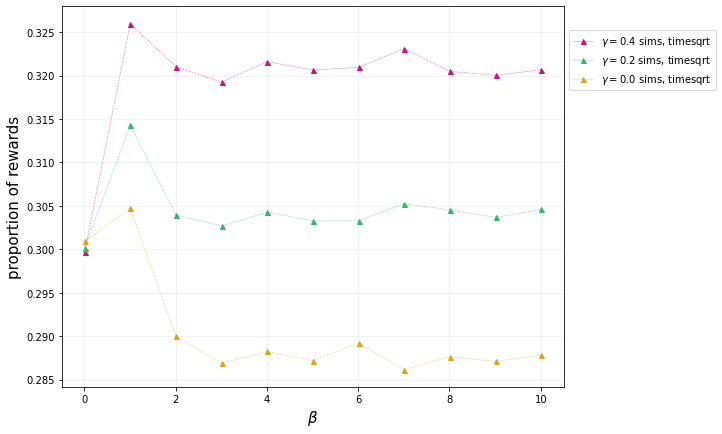

In [460]:
f, ax = plt.subplots(figsize=(9,7))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [2,1,0]:
    ax.plot(simBetas, sqrRews[i], color=colors[i], alpha=1, 
            label='$\gamma={:0.1f}$ sims, timesqrt'.format(gammas[i]), 
            marker='^', fillstyle='full', linestyle='dotted', markersize=5, linewidth=0.6)


ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [457]:
scale   = 3
sample1 = np.random.rayleigh(scale=scale/np.sqrt(2), size=100000)
sample2 = scale*np.random.exponential(scale=1, size=100000)**(1/2)
betas   = np.arange(0.1, 10.2, 0.001)
theo    = (1-np.exp(-((betas**2)/(2*((scale/np.sqrt(2))**2)))))

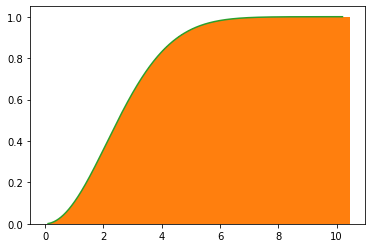

In [458]:
plt.hist(sample1, bins=1000, cumulative=True, density=True)
plt.hist(sample2, bins=1000, cumulative=True, density=True)
plt.plot(betas, theo)
plt.show()

In [383]:
# X + \sqrt(X)
np.random.rayleigh(), np.random.exponential()**(1/2)

(2.06639925959013, 1.4069569443359946)

In [396]:
sample1 = np.random.rayleigh(scale=1/np.sqrt(2), size=100000)
sample2 = np.random.exponential(scale=1, size=100000)**(1/2)

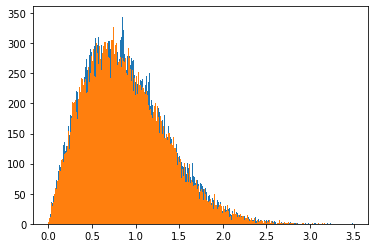

In [397]:
plt.hist(sample1, bins=1000)
plt.hist(sample2, bins=1000)
plt.show()

In [398]:
sample1.mean(), sample2.mean()

(0.8876147558681622, 0.8848340281205467)

In [399]:
# SUM CDF from convolution 
def sumCDF(beta):
    return 1/2*np.exp(-beta) * (1-np.exp(-(beta**2)))

In [425]:
betas = np.arange(0.1, 12, 0.001)
theo  = sumCDF(betas)

In [416]:
testCDF = np.random.exponential(size=int(1e5)) + np.random.rayleigh(scale=1/np.sqrt(2), size=int(1e5))
testCDF.shape

(100000,)

In [418]:
testCDF2 = np.random.exponential(size=int(1e5))
testCDF2 = testCDF2 + np.sqrt(testCDF2) 
testCDF2.shape

(100000,)

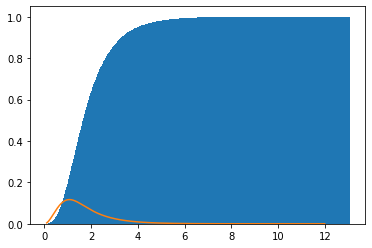

In [427]:
plt.hist(testCDF, bins=1000, cumulative=True, density=True)
plt.plot(betas, theo)
# plt.hist(testCDF2, bins=1000)
plt.show()

In [423]:
testCDF.var(), testCDF2.var()

(1.2213497274777667, 2.123352969909713)

In [414]:
sample = np.random.exponential()
sample+np.sqrt(sample)

1.7983840638723032

In [24]:
# R_f general
a, b, g = sp.symbols('alpha beta gamma')

A_expr = a * (sp.exp(-b) / (a*(1-sp.exp(-b))) + 2 - a + ((2-a)/(1-a)) + ((((1-a)**2)*g)/a) + (a**2/((1-2*a)*(1-a))))
H_expr = (1-a) / (a*(1-sp.exp(-b))) + ((1-a)**2)*(2-g) + a*(1-a)

R_f = A_expr / (A_expr + H_expr)

In [25]:
simplified_Rf = sp.simplify(R_f)
simplified_Rf

alpha*(2*alpha**3*gamma*exp(beta) - 2*alpha**3*gamma - 2*alpha**3*exp(beta) + 2*alpha**3 - 5*alpha**2*gamma*exp(beta) + 5*alpha**2*gamma + 8*alpha**2*exp(beta) - 8*alpha**2 + 4*alpha*gamma*exp(beta) - 4*alpha*gamma - 4*alpha*exp(beta) + 6*alpha - gamma*exp(beta) + gamma - 1)/(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta))

In [27]:
# R_e general
expr1 = (1 + b * ((1-a)**2)*(1-g)) / (sp.exp(b)-1) + 5*a + ((1-a)**2)*g + 2*(a**2)/(1-2*a) - 2*(a**2)
expr2 = (a*(1-2*a)*(1-sp.exp(-b))) / (1-2*sp.exp(-b)*a-3*(1-sp.exp(-b))*(a**2))

R_e = expr1 * expr2
simplified_Re = sp.simplify(R_e)
simplified_Re

alpha*(2*alpha**2*(1 - exp(beta)) - (1 - exp(beta))*(2*alpha - 1)*(-2*alpha**2 + 5*alpha + gamma*(alpha - 1)**2) + (2*alpha - 1)*(-beta*(alpha - 1)**2*(gamma - 1) + 1))/(-3*alpha**2*(1 - exp(beta)) + 2*alpha - exp(beta))

In [28]:
l = sp.symbols('lambda')
R_t = (simplified_Rf + l * simplified_Re) / (l + 1)
simplified_Rt = sp.simplify(R_t)
simplified_Rt

alpha*(-lambda*(2*alpha**2*(1 - exp(beta)) - (1 - exp(beta))*(2*alpha - 1)*(-2*alpha**2 + 5*alpha + gamma*(alpha - 1)**2) - (2*alpha - 1)*(beta*(alpha - 1)**2*(gamma - 1) - 1))*(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta)) - (3*alpha**2*(1 - exp(beta)) - 2*alpha + exp(beta))*(-2*alpha**3*gamma*exp(beta) + 2*alpha**3*gamma + 2*alpha**3*exp(beta) - 2*alpha**3 + 5*alpha**2*gamma*exp(beta) - 5*alpha**2*gamma - 8*alpha**2*exp(beta) + 8*alpha**2 - 4*alpha*gamma*exp(beta) + 4*alpha*gamma + 4*alpha*exp(beta) - 6*alpha + gamma*exp(beta) - gamma + 1))/((lambda + 1)*(3*alpha**2*(1 - exp(beta)) - 2*alpha + exp(beta))*(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta)))

In [30]:
lim = sp.limit(simplified_Rt, b, sp.oo)

In [31]:
print(lim.evalf(subs={l:1., a:0.3, g:1.00})) 

0.373575037007448


In [34]:
Ours(a=0.3, b=35, gamma=1., scale=1.)

0.37357503700744843

In [29]:
simplified_Rt.evalf(subs={l:1., a:0.3, g:1.0})

0.15*(-1.0*(0.183 - 0.583*exp(beta))*(0.504 - 0.904*exp(beta)) - (0.73*exp(beta) - 0.33)*(0.73*exp(beta) - 0.33))/((0.183 - 0.583*exp(beta))*(0.73*exp(beta) - 0.33))